# **Preparación entorno**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/TFM/data/calc_df.csv"
df = pd.read_csv(data_path)

In [ ]:
# Importamos las liberías necesarias
import numpy as np
import pandas as pd
import cv2
import PIL
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import glob
import random
import os
from os import listdir
import glob


# **Análisis Exploratorio**

| **Atributo**                | **Descripción**                                                                                                     |
| --------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **patient\_id**             | Identificador único del paciente. Permite agrupar datos e imágenes asociadas a una misma persona.                   |
| **breast density**          | Densidad del tejido mamario (escala 1 a 4). A mayor densidad, más difícil es detectar anomalías.                    |
| **left or right breast**    | Indica si la imagen corresponde al seno **izquierdo (LEFT)** o **derecho (RIGHT)**.                                 |
| **image view**              | Tipo de vista de la mamografía. Las más comunes son **CC (cráneo-caudal)** y **MLO (oblicua medio-lateral)**.       |
| **abnormality id**          | ID que identifica una anomalía específica en la imagen. Puede haber varias por imagen.                              |
| **abnormality type**        | Calcificación                                                   |
| **calc type**               | Tipo de calcificación (si aplica), como **AMORPHOUS** o **PLEOMORPHIC**. Puede estar vacío si no hay calcificación. |
| **calc distribution**       | Distribución espacial de las calcificaciones (ej. **CLUSTERED**, **LINEAR**, **REGIONAL**).                         |
| **assessment**              | Evaluación del riesgo radiológico según BI-RADS. Escala ordinal que indica la sospecha de malignidad.               |
| **pathology**               | Resultado clínico o de biopsia: puede ser **MALIGNANT**, **BENIGN**, o **BENIGN\_WITHOUT\_CALLBACK**.               |
| **subtlety**                | Nivel de sutileza visual de la anomalía (1 a 5). A mayor valor, más difícil es de detectar.                         |
| **image file path**         | Ruta al archivo de imagen original.                                                                                 |
| **cropped image file path** | Ruta al archivo de imagen recortada centrada en la anomalía.                                                        |
| **ROI mask file path**      | Ruta al archivo de la máscara binaria que señala la región de interés (la anomalía).                                |



In [ ]:
df.shape

(1872, 14)

In [ ]:
df.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1872 non-null   object
 1   breast density           1872 non-null   int64 
 2   left or right breast     1872 non-null   object
 3   image view               1872 non-null   object
 4   abnormality id           1872 non-null   int64 
 5   abnormality type         1872 non-null   object
 6   calc type                1848 non-null   object
 7   calc distribution        1433 non-null   object
 8   assessment               1872 non-null   int64 
 9   pathology                1872 non-null   object
 10  subtlety                 1872 non-null   int64 
 11  image file path          1872 non-null   object
 12  cropped image file path  1872 non-null   object
 13  ROI mask file path       1872 non-null   object
dtypes: int64(4), object(10)
memory usage: 20

In [ ]:
df.isnull().sum()

,0
patient_id,0
breast density,0
left or right breast,0
image view,0
abnormality id,0
abnormality type,0
calc type,24
calc distribution,439
assessment,0
pathology,0


In [ ]:
# Ver los valores únicos y su frecuencia
df['calc distribution'].value_counts(dropna=False)

,count
calc distribution,
CLUSTERED,935
NaN,439
SEGMENTAL,202
LINEAR,112
REGIONAL,102
DIFFUSELY_SCATTERED,40
CLUSTERED-LINEAR,29
LINEAR-SEGMENTAL,7
CLUSTERED-SEGMENTAL,5


In [ ]:
# Revisamos los duplicados de patient_ids que contenga los mismos valores en la fila
duplicated_ids_with_same_rows = df[df.duplicated(subset=['patient_id'], keep=False)].groupby('patient_id').filter(lambda x: len(x) > 1 and x.drop('patient_id', axis=1).duplicated().any())

# Contamos cuántos duplicados hay y mostramos resultado
num_duplicated_ids_with_same_rows = duplicated_ids_with_same_rows['patient_id'].nunique()
print(num_duplicated_ids_with_same_rows)

0


**Debemos tener cuidado al dividir el dataset en train/test, debemos asegurar no mezclar imágenes del mismo paciente en ambos conjuntos (riesgo de data leakage)**

* *Data leakage: Use of information in the model training process which would not be expected to be available at prediction time, causing the predictive scores (metrics) to overestimate the model's utility when run in a production environment.*

In [ ]:
df.describe()

,breast density,abnormality id,assessment,subtlety
count,1872.000000,1872.000000,1872.000000,1872.000000
mean,2.669338,1.380342,3.292735,3.395299
std,0.932322,0.853576,1.224108,1.181426
min,0.000000,1.000000,0.000000,1.000000
25%,2.000000,1.000000,2.000000,3.000000
50%,3.000000,1.000000,4.000000,3.000000
75%,3.000000,1.000000,4.000000,4.000000
max,4.000000,7.000000,5.000000,5.000000


In [ ]:
df.head(10)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
5,P_00008,1,LEFT,CC,2,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
6,P_00008,1,LEFT,CC,3,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
7,P_00008,1,LEFT,MLO,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
8,P_00008,1,LEFT,MLO,2,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
9,P_00008,1,LEFT,MLO,3,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...


## Distribución de variables numéricas y Boxplots

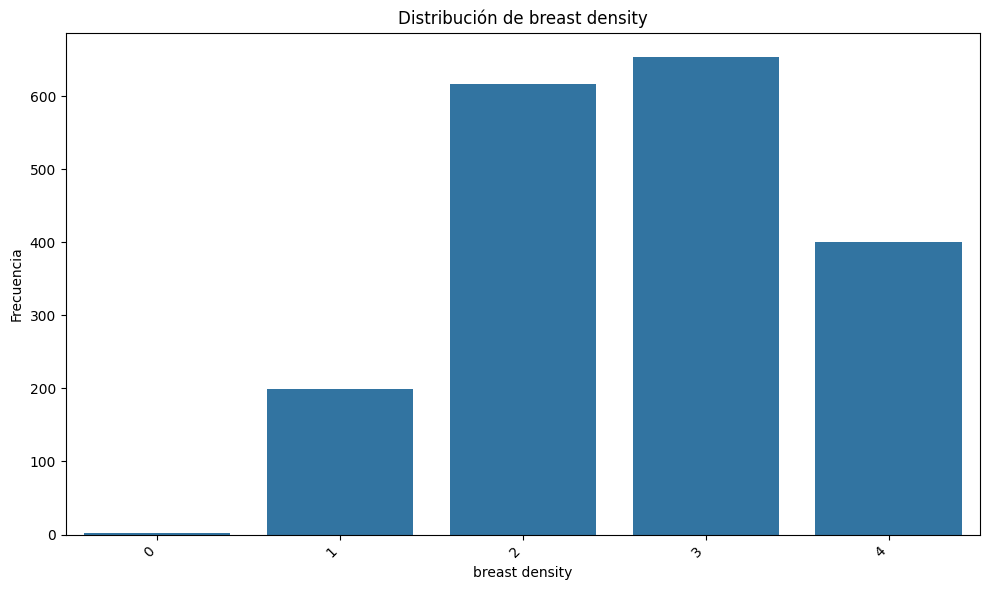

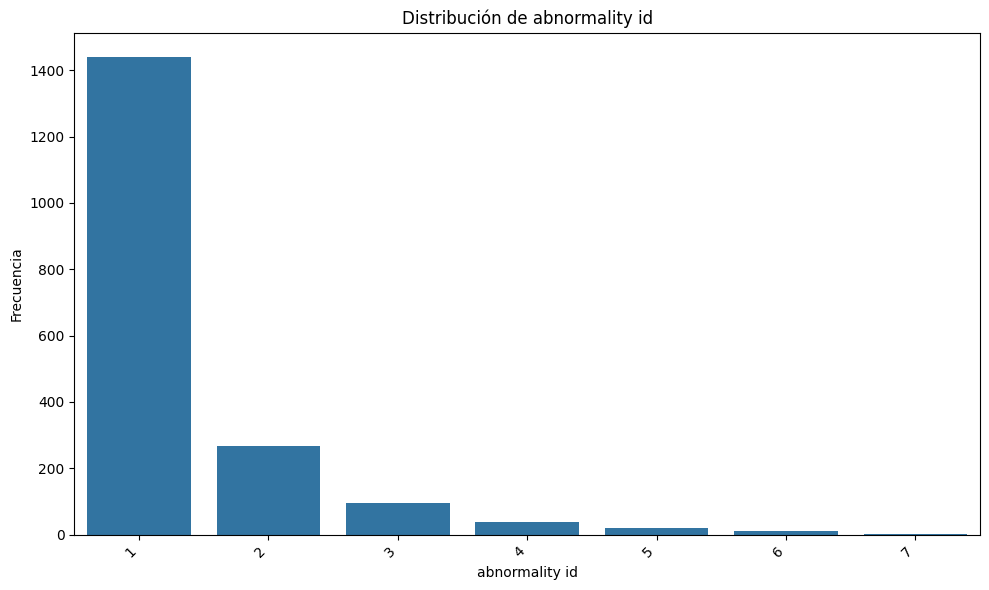

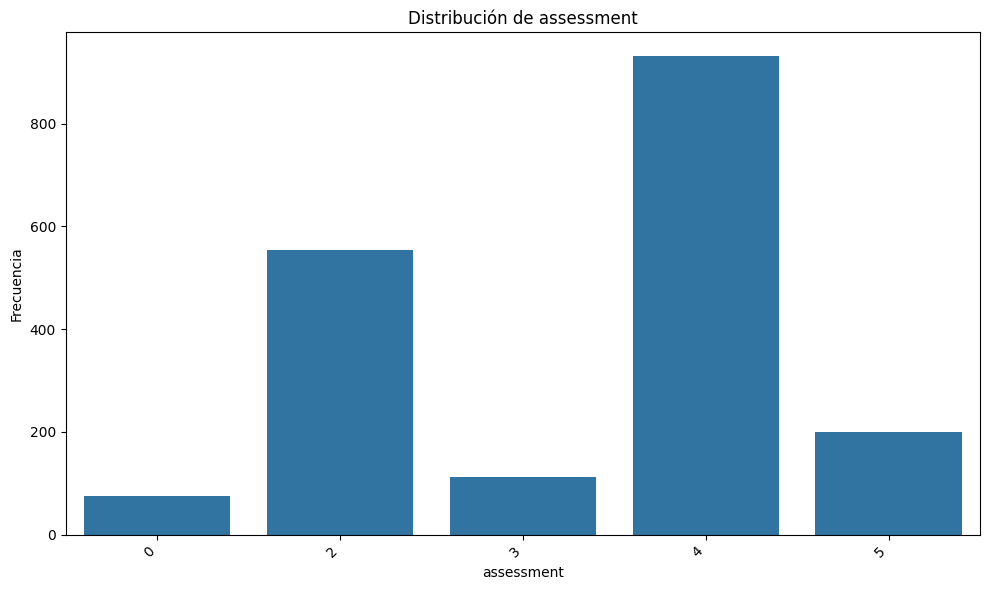

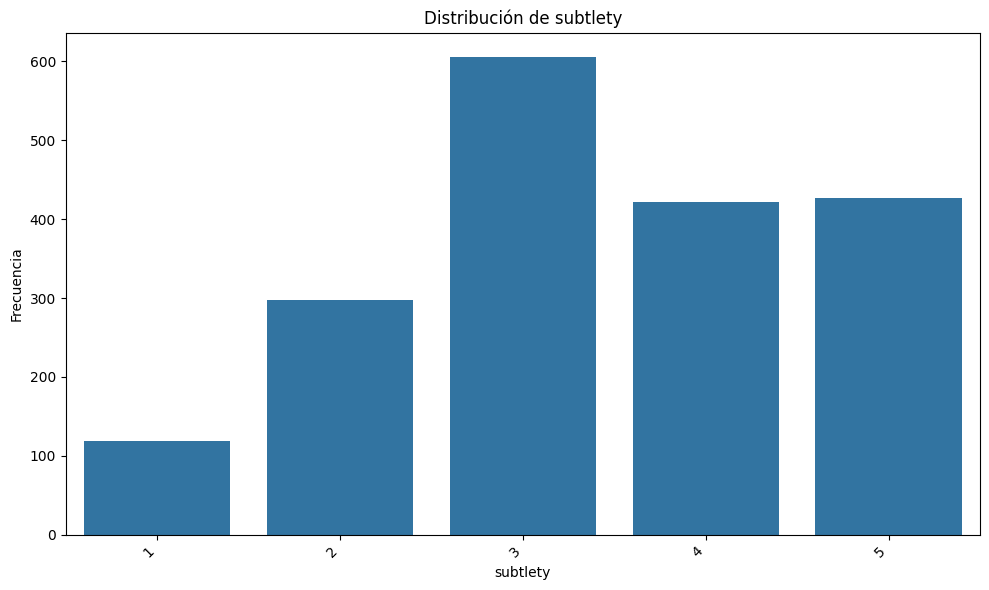

In [ ]:
# Seleccionamos solo las columnas numéricas
df_numeric = df.select_dtypes(include=np.number)

# Obtenemos los nombres de las columnas numéricas
numeric_cols = df_numeric.columns

# Iteramos por cada columna numérica y creamos gráfico de barras
for col in numeric_cols:
    # Obtenemos el conteo de valores y ordenamos por el valor numérico
    value_counts = df[col].value_counts().sort_index()

    # Creamos el gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

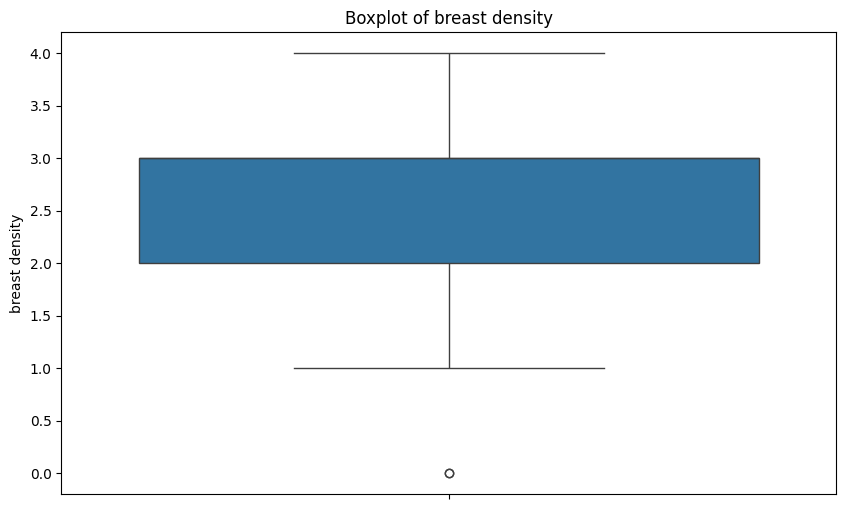

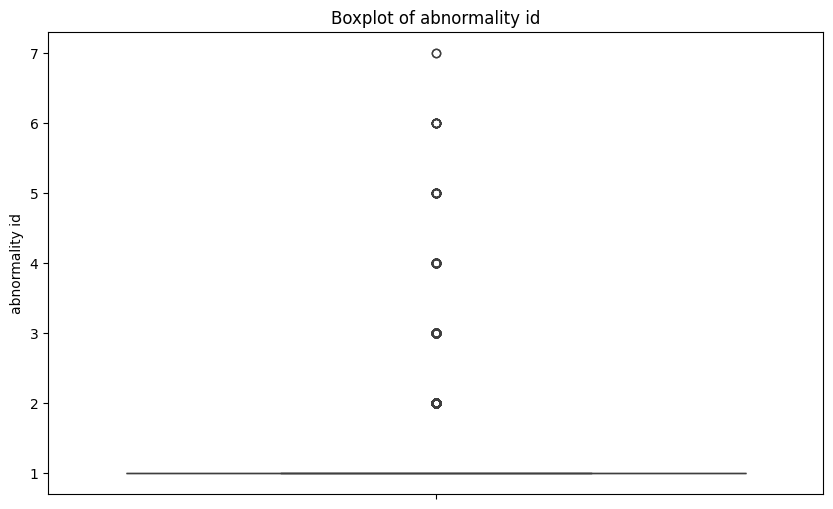

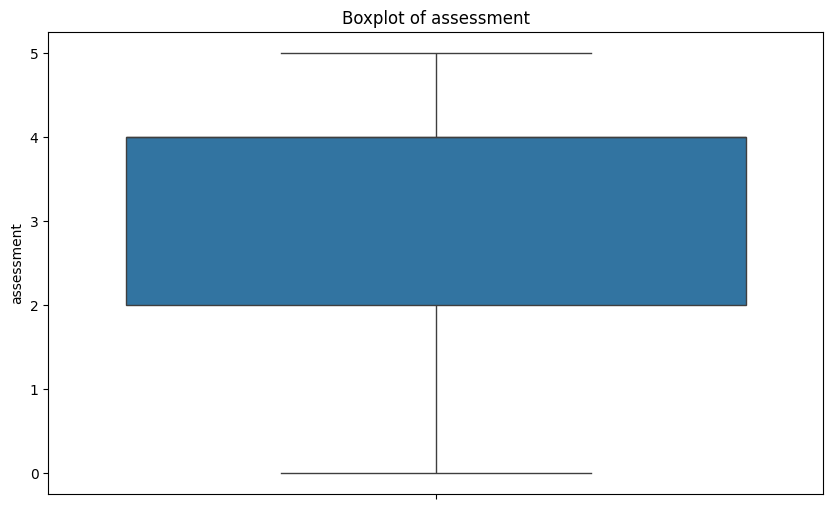

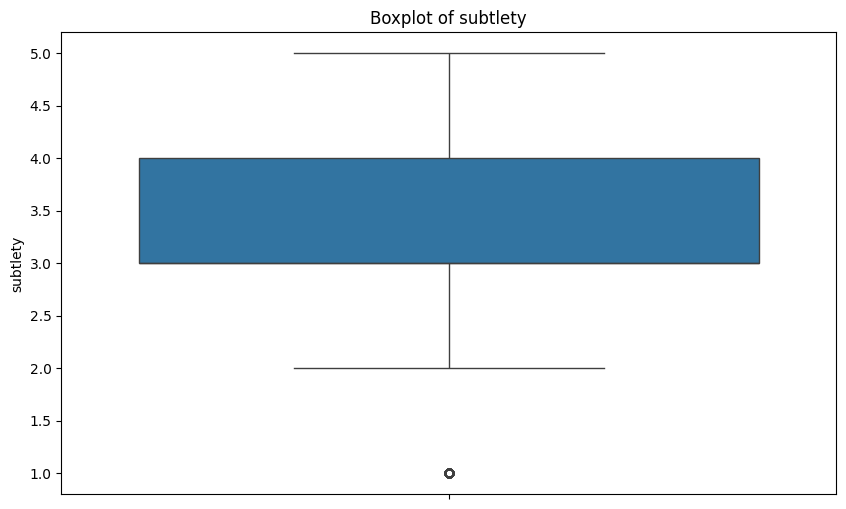

In [ ]:
# Iteramos y creamos boxplot
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

## Análisis exploratorio de variables

### 1. Distribución de `breast density`
- La densidad mamaria se distribuye mayoritariamente entre los valores 2 y 3, lo que es esperable según la escala BI-RADS.
- Se detecta un valor atípico igual a 0, que no forma parte de la escala (que va de 1 a 4). Este valor probablemente representa un error o valor faltante codificado incorrectamente.
- Acción recomendada: reemplazar el valor 0 por NaN y considerar su eliminación o imputación.

### 2. Distribución de `abnormality id`
- La mayoría de los casos presentan una única anomalía (`abnormality id = 1`), mientras que los valores superiores son mucho menos frecuentes.
- Esto refleja que muchas mamografías están asociadas a una sola anomalía, pero existen casos con múltiples hallazgos.
- Acción recomendada: tener en cuenta esta variable si se agrupan imágenes por paciente o por anomalía.

### 3. Distribución de `assessment` (nivel de sospecha radiológica)
- La clase más común es `assessment = 4`, indicando una alta sospecha de malignidad.
- Se observa la presencia de valores igual a 0, que podrían no ser válidos según la escala esperada.
- Acción recomendada: revisar documentación del dataset para entender si el valor 0 es interpretable o se debe tratar como error.

### 4. Distribución de `subtlety` (nivel de sutileza visual de la anomalía)
- La distribución está centrada en valores 3, 4 y 5, lo cual es consistente con la dificultad media-alta para detectar anomalías.
- El valor mínimo es 1, presente en menor proporción, representando casos con anomalías muy evidentes.
- Acción recomendada: mantener la variable para entender la dificultad de clasificación en los modelos posteriores.

## Detección de valores outliers (boxplots)

- `breast density`: el valor 0 es un outlier claro y debe tratarse como tal.
- `abnormality id`: muestra varios valores atípicos pero es esperable ya que representa identificadores, no medidas continuas.
- `assessment`: distribución esperada, aunque se confirma que el valor 0 es potencialmente anómalo.
- `subtlety`: no hay valores extremos inesperados, distribución razonable.

---

## Conclusiones preliminares

1. **Limpieza necesaria**:
   - Revisión y posible eliminación de registros con `breast density = 0` y `assessment = 0`.
2. **Próximos análisis recomendados**:
   - Revisar la variable `pathology` (MALIGNANT, BENIGN...) y su balance.
   - Analizar correlaciones cruzadas como:
     - `assessment` vs. `pathology`
     - `subtlety` vs. `pathology`
     - `breast density` vs. `pathology`
3. **A tener en cuenta para el modelado**:
   - Varias imágenes por paciente → evitar *data leakage*.
   - Decidir si se agrupará por `patient_id` o se mantendrán entradas por imagen.

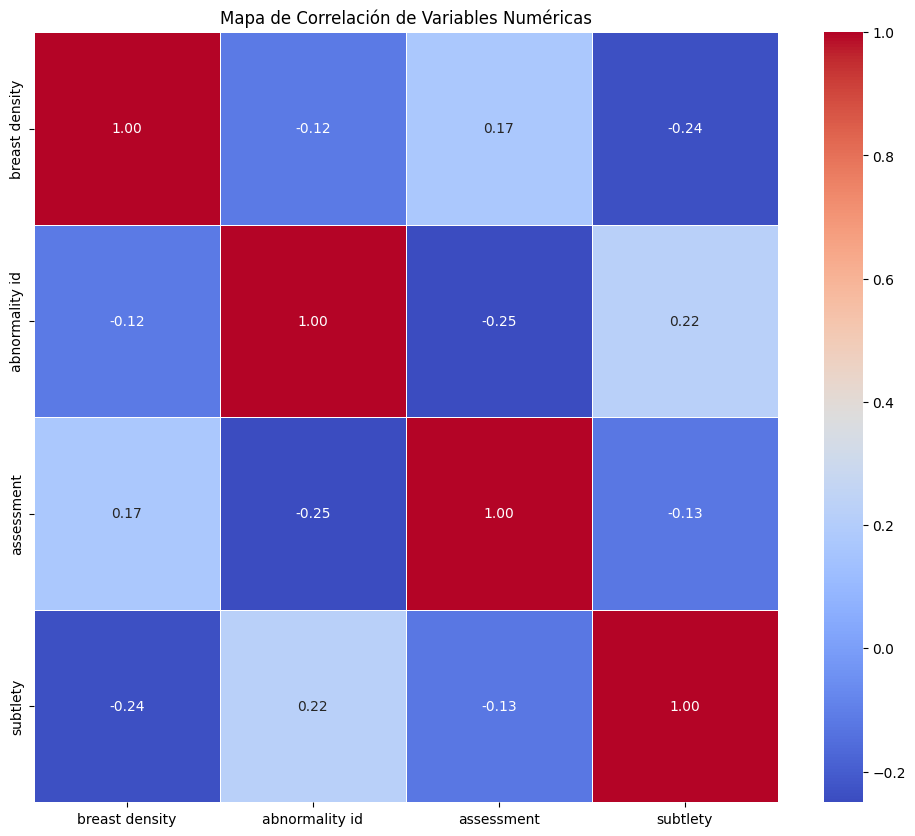

In [ ]:
correlation_matrix = df_numeric.corr()

# Creamos mapa de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación de Variables Numéricas')
plt.show()

## Análisis de Correlación entre Variables Numéricas

Se ha generado una matriz de correlación entre las principales variables numéricas del dataset (`breast density`, `abnormality id`, `assessment` y `subtlety`) utilizando el coeficiente de correlación de Pearson.

### Interpretación de la matriz:

- **No existen correlaciones fuertes** entre las variables analizadas. Todas se sitúan en un rango de -0.25 a 0.22.
- Las correlaciones más destacadas, aunque débiles, son:
  - `assessment` y `abnormality id`: **correlación negativa** (-0.25), lo que sugiere que un mayor número de anomalías no implica necesariamente una mayor sospecha de malignidad.
  - `subtlety` y `abnormality id`: **correlación positiva leve** (0.22), lo que podría indicar que más anomalías tienden a tener una mayor sutileza visual.
  - `breast density` y `assessment`: **correlación positiva leve** (0.17), es decir, una mayor densidad mamaria podría asociarse ligeramente con un mayor nivel de sospecha radiológica.

### Conclusiones:

- Las variables no muestran multicolinealidad, lo cual es positivo para futuros modelos predictivos.
- La variable `assessment` parece tener relaciones débiles pero interesantes con otras variables clínicas y podría ser útil como variable predictora.
- Recomendación: profundizar más con gráficos de dispersión o análisis categóricos cruzando con `pathology`, que es la etiqueta de clasificación principal (maligno/benigno).


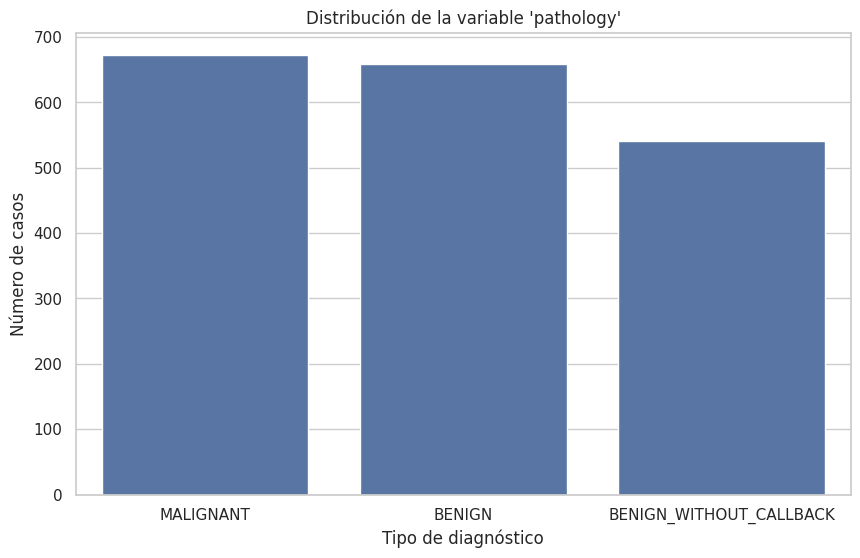

In [ ]:
import seaborn as sns

# Ajustes generales de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# Distribución de la variable objetivo: pathology
sns.countplot(data=df, x='pathology', order=df['pathology'].value_counts().index)
plt.title("Distribución de la variable 'pathology'")
plt.xlabel("Tipo de diagnóstico")
plt.ylabel("Número de casos")
plt.show()

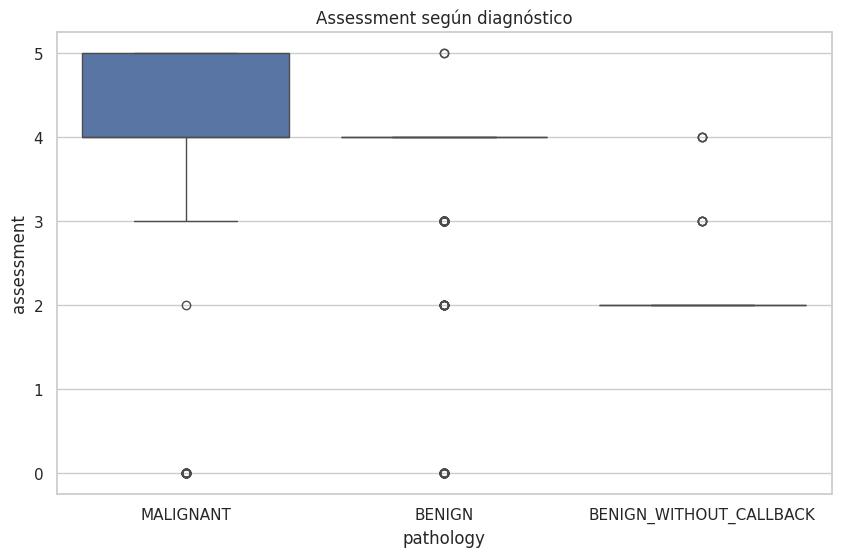

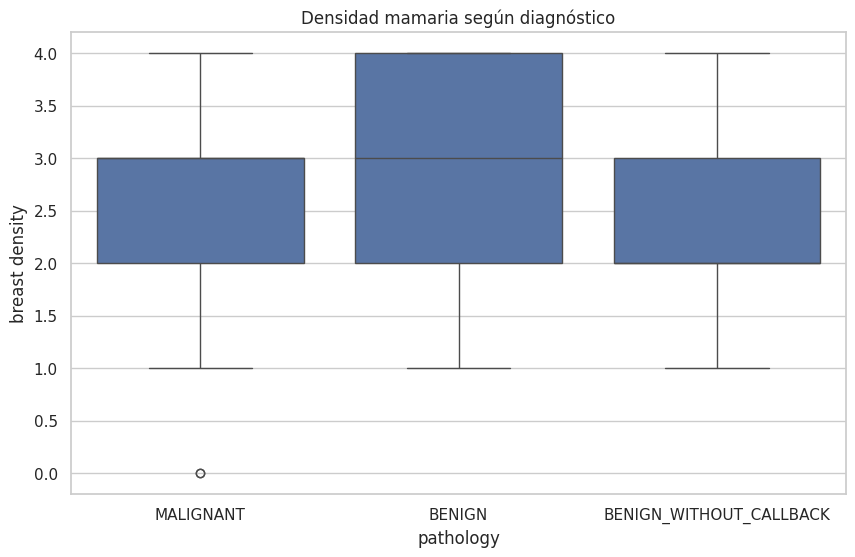

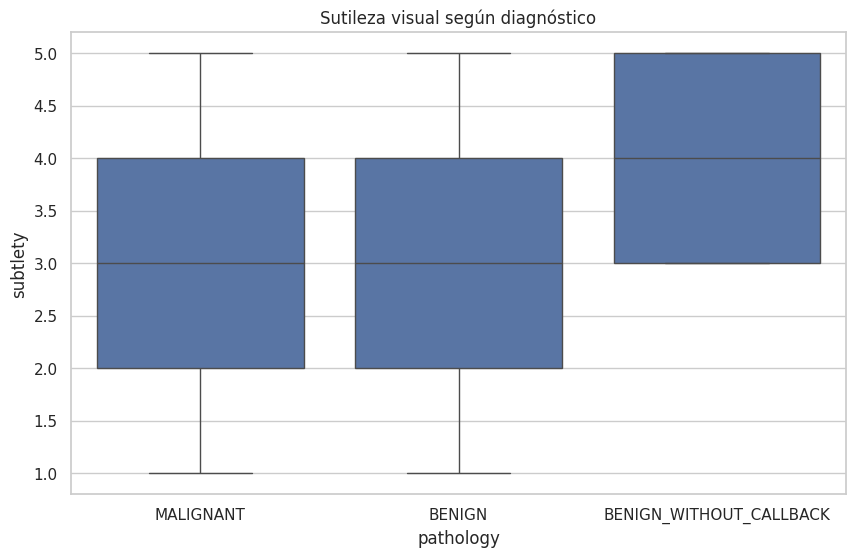

In [ ]:
# Boxplot comparativo de Assessment y Pathology
sns.boxplot(x='pathology', y='assessment', data=df)
plt.title("Assessment según diagnóstico")
plt.show()

# Boxplot comparativo de Breast Density y Pathology
sns.boxplot(x='pathology', y='breast density', data=df)
plt.title("Densidad mamaria según diagnóstico")
plt.show()

# Boxplot comparativo de Subtlety y Pathology
sns.boxplot(x='pathology', y='subtlety', data=df)
plt.title("Sutileza visual según diagnóstico")
plt.show()

## Análisis de la variable objetivo: `pathology`

### Distribución de clases
- El dataset está compuesto por tres categorías:
  - `MALIGNANT`: ~670 casos
  - `BENIGN`: ~660 casos
  - `BENIGN_WITHOUT_CALLBACK`: ~540 casos
- **No existe un desbalance extremo**, lo cual es positivo para la fase de clasificación. Aun así, puede evaluarse si se fusionan las clases benignas según el objetivo del modelo (binario vs multiclase).

## Variables clínicas según diagnóstico

### Assessment (nivel de sospecha radiológica)
- `MALIGNANT` tiene una mediana de 5, y la mayoría de los valores están entre 4 y 5, lo que **confirma la coherencia** entre sospecha clínica y resultado.
- Las categorías benignas se centran en valores de 2 a 4, pero también muestran valores altos y bajos → pueden existir **falsos positivos o incertidumbre clínica**.

### Breast density (densidad mamaria)
- Las tres clases presentan distribuciones similares.
- Se detectan valores **atípicos de densidad = 0** que deberían tratarse.
- No parece haber una gran diferencia en densidad entre benigno y maligno.

### Subtlety (nivel de dificultad visual)
- `BENIGN_WITHOUT_CALLBACK` tiene valores más altos de sutileza (dificultad para detectar), lo que **tiene sentido clínico** al tratarse de lesiones que no generaron revisión adicional.
- `MALIGNANT` y `BENIGN` tienen distribuciones similares, lo cual refuerza la idea de que algunas lesiones benignas pueden ser visualmente similares a las malignas.

---

## Conclusiones del análisis visual:

- `assessment` es una variable fuerte para predecir malignidad.
- `breast density` y `subtlety` pueden tener un rol secundario, pero útil.
- Se confirma que las etiquetas están bien distribuidas, lo que permite entrenar modelos tanto **binarios** (maligno vs no maligno) como **multiclase**.

Un aspecto importante de la variable objetivo es que sus valores sean consistentes entre la imagen CC y MLO para una misma lesión del mismo paciente, es decir, que no tengamos para un paciente en la mama derecha una imagen CC como maligna y una imagen MLO como benigna.

## Distribución de variables categóricas

In [ ]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

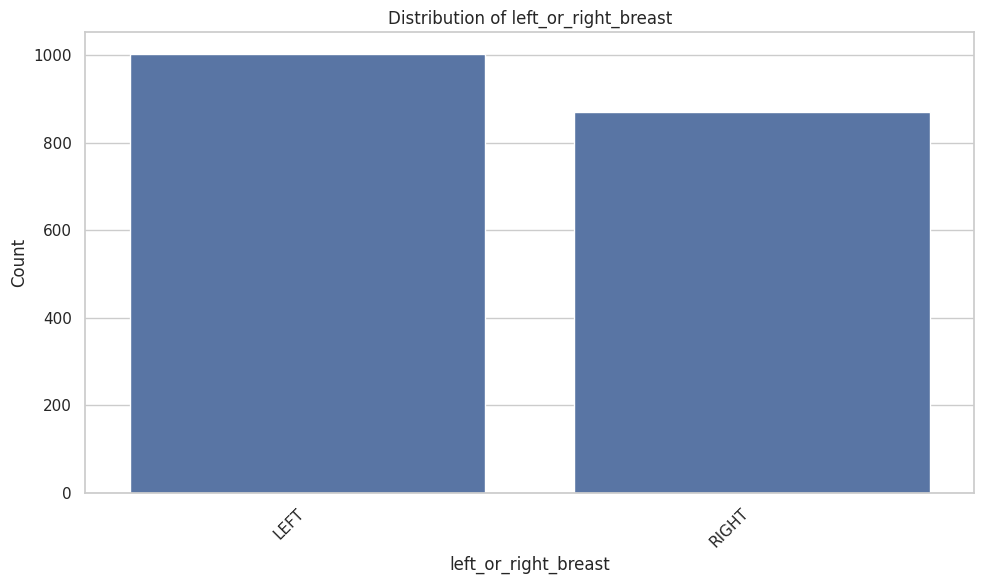

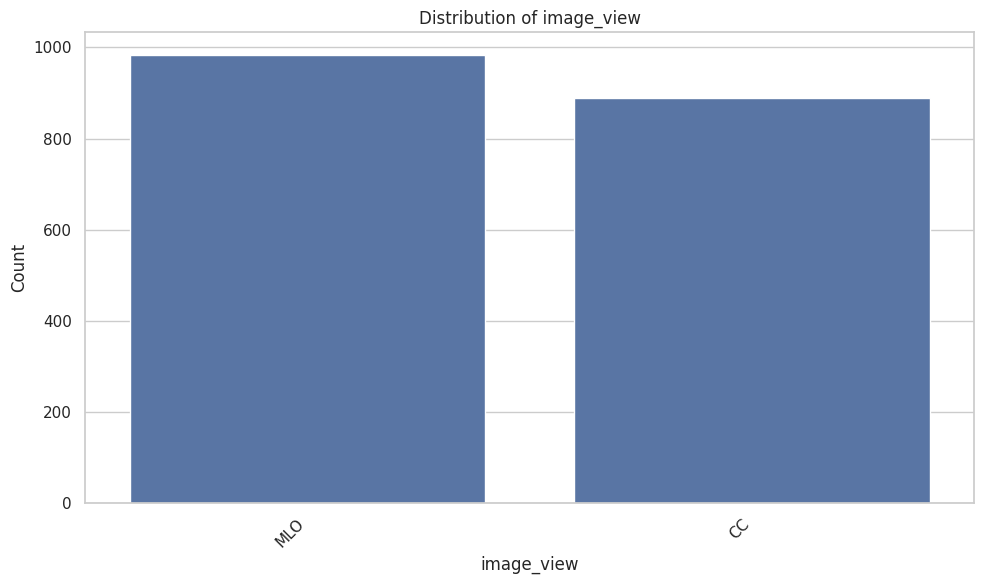

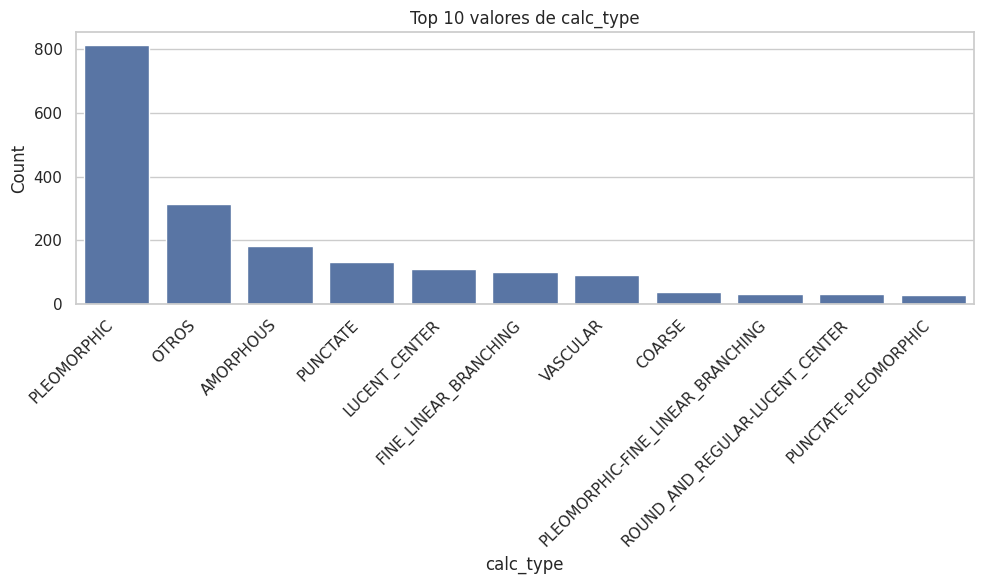

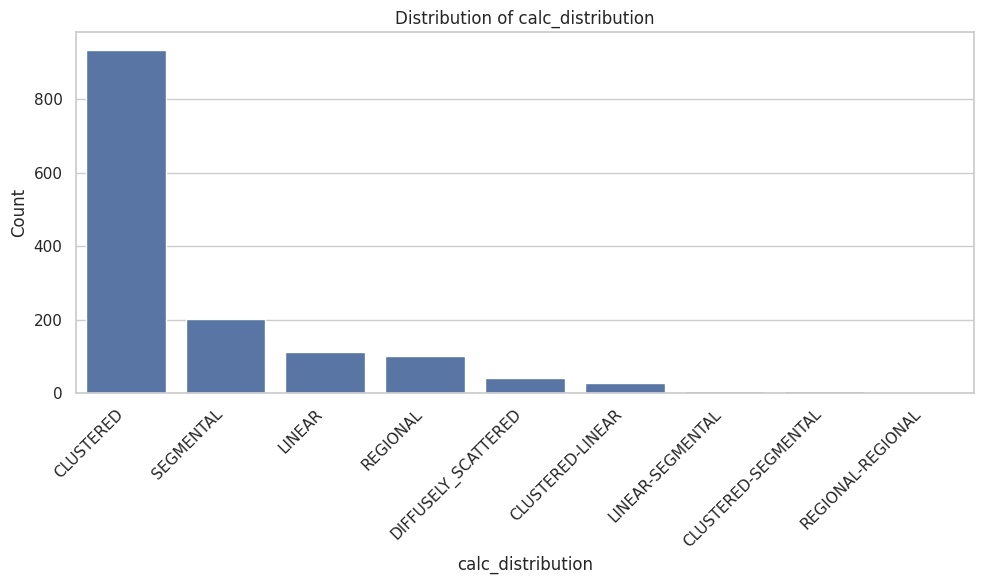

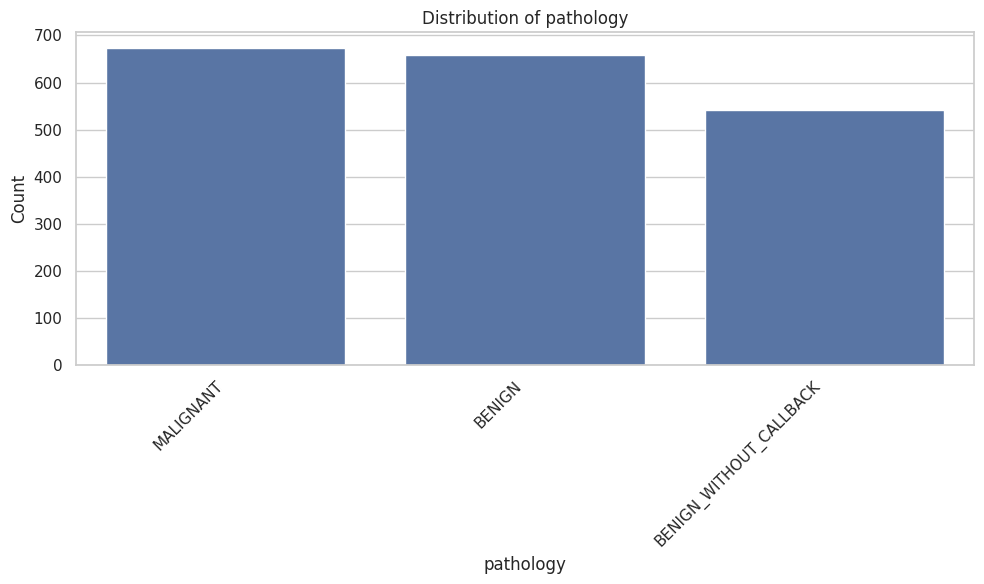

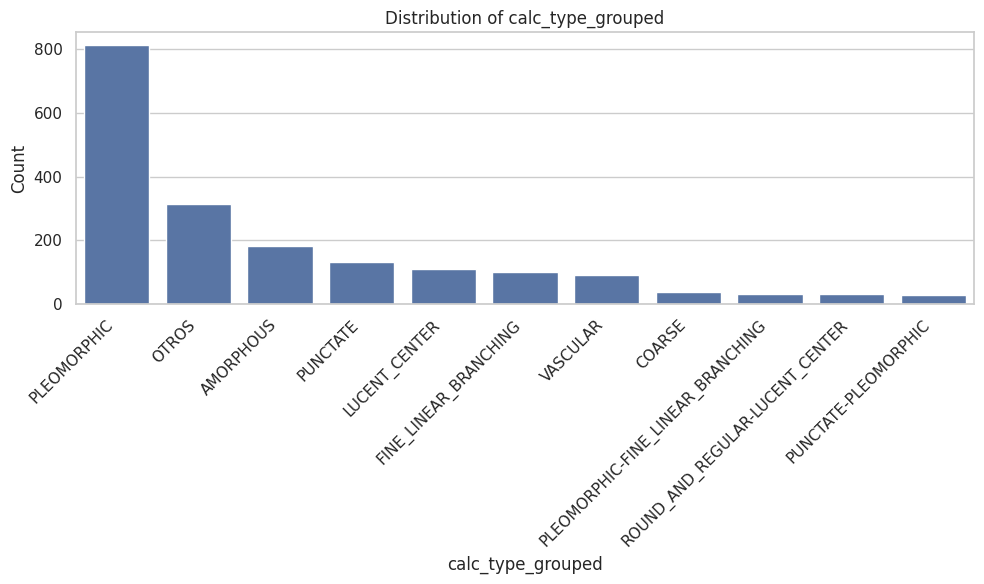

In [ ]:
excluded_cols = ['patient_id', 'image_file_path', 'ROI_mask_file_path', 'cropped_image_file_path']
categorical_cols = df.select_dtypes(include='object').columns

top_n = 10  # Número de categorías a mostrar en el top

for col in categorical_cols:
    if col not in excluded_cols:
        value_counts = df[col].value_counts()

        if len(value_counts) > 1:  # evita columnas vacías
            plt.figure(figsize=(10, 6))

            if col == 'calc_type':
                # Agrupar en 'OTROS' si no está en el Top N
                top_categories = value_counts.nlargest(top_n)
                df['calc_type_grouped'] = df['calc_type'].apply(
                    lambda x: x if x in top_categories.index else 'OTROS'
                )
                grouped_counts = df['calc_type_grouped'].value_counts()
                sns.barplot(x=grouped_counts.index.astype(str), y=grouped_counts.values)
                plt.title(f'Top {top_n} valores de {col}')
            else:
                sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
                plt.title(f'Distribution of {col}')

            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

## Análisis de Variables Categóricas

### 1. `patient_id`
- La distribución muestra una gran cantidad de pacientes únicos, la mayoría con entre 1 y 5 imágenes.
- Algunos casos tienen hasta 20 o más registros, lo que indica múltiples vistas o anomalías por paciente.
- **Recomendación**: evitar que imágenes del mismo `patient_id` aparezcan en train y test para prevenir *data leakage*.

### 2. `left or right breast`
- Aproximadamente:
  - 1000 imágenes del seno izquierdo (`LEFT`)
  - 870 del derecho (`RIGHT`)
- La distribución es razonablemente equilibrada.

### 3. `image view`
- Dos tipos principales:
  - `MLO` (oblicua medio-lateral): ~980 casos
  - `CC` (cráneo-caudal): ~890 casos
- Buena representación de ambos tipos de vista. Pueden usarse como variable predictiva si se entrena un modelo con metadatos.

### 4. `calc type`
- Alta cardinalidad: hay **muchos tipos únicos de calcificación**, probablemente derivados de combinaciones.
- `PLEOMORPHIC` y `AMORPHOUS` son los más frecuentes.
- **Recomendación**:
  - Agrupar los tipos menos frecuentes bajo categoría `"OTHER"` para evitar overfitting.
  - O codificar solo los 5 más comunes.

### 5. `calc distribution`
- `CLUSTERED` domina claramente el conjunto (~900 casos).
- Las siguientes más comunes: `SEGMENTAL`, `LINEAR`, `REGIONAL`.
- Algunas combinaciones tienen muy baja frecuencia.
- **Recomendación**: aplicar un enfoque similar al anterior: agrupar o eliminar categorías raras.

### 6. `pathology` (variable objetivo)
- Ya analizada previamente. Distribución bastante balanceada entre las tres clases.

## Conclusiones para preprocesamiento:

- Es importante **reducir la cardinalidad** en `calc type` y `calc distribution`.
- Variables como `left or right breast`, `image view` o incluso `calc distribution` podrían ser útiles como features.
- Se confirma la necesidad de **stratified split** por `patient_id` si se hace modelado supervisado.

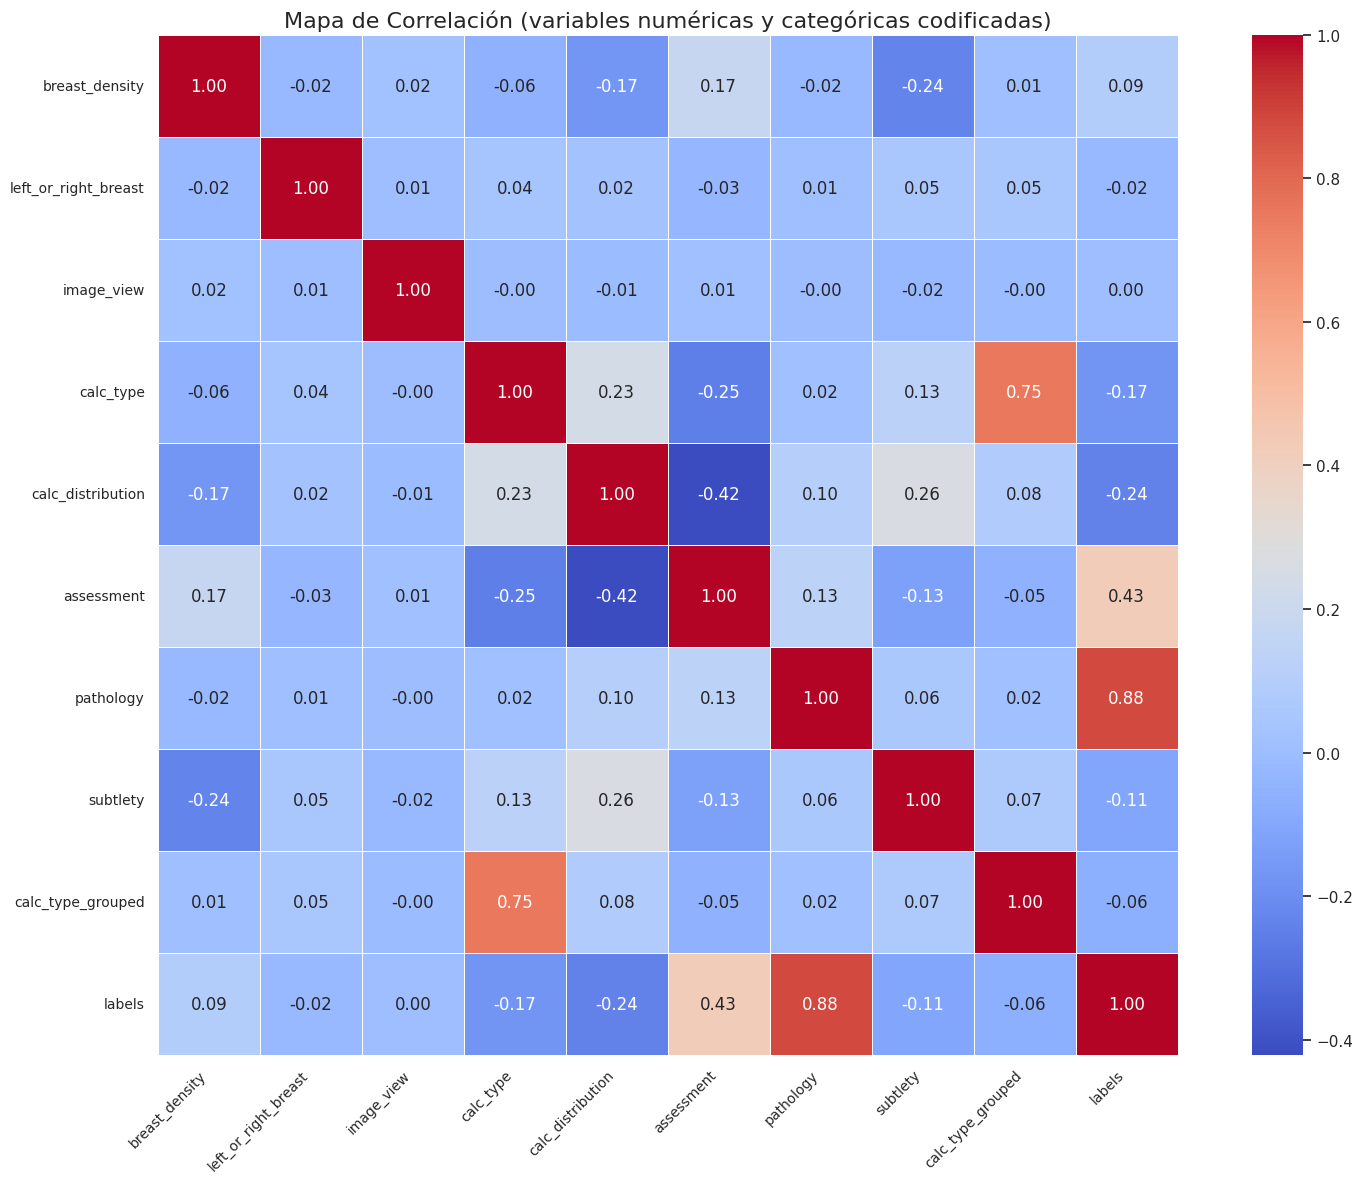

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copiamos el dataframe y codificamos variables categóricas
df_enc = df.copy()
for col in df_enc.select_dtypes(include='object').columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col].astype(str))

# Definimos las columnas que queremos eliminar
drop_cols = [
    'patient_id',
    'abnormality_id',
    'image_file_path',
    'cropped_image_file_path',
    'ROI_mask_file_path',
    'abnormality_type'
]

# Eliminamos las columnas innecesarias
df_enc = df_enc.drop(columns=drop_cols)

# Creamos el mapa de correlaciones
plt.figure(figsize=(16, 12))
sns.heatmap(df_enc.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title("Mapa de Correlación (variables numéricas y categóricas codificadas)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Índice de Gini

/tmp/ipython-input-48-3881354304.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gini Index', y=gini_df.index, data=gini_df, palette='Blues_d')


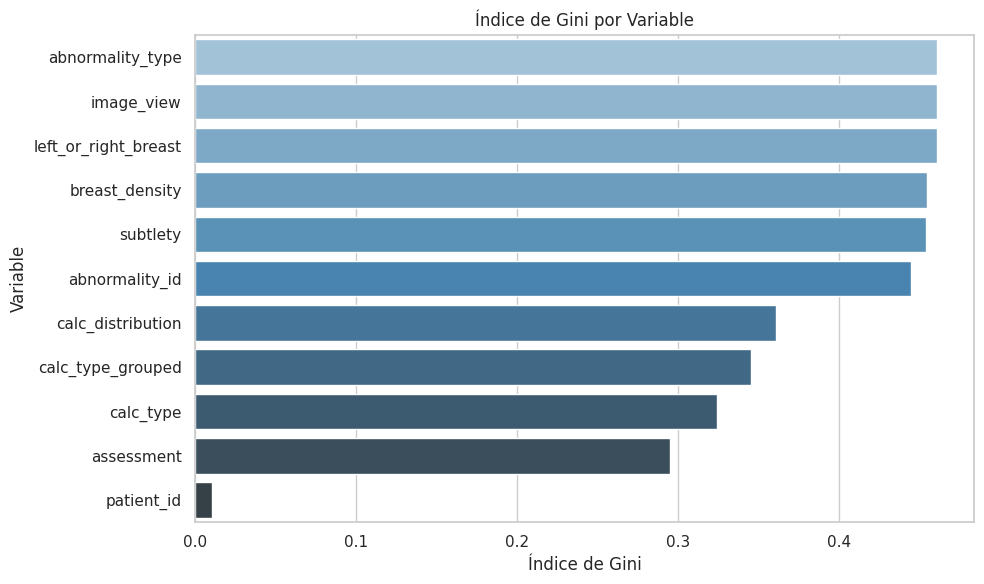

In [ ]:
def gini_impurity(probs):
    """Calcula la impureza de Gini dada una lista de probabilidades."""
    return 1 - np.sum(np.square(probs))

def gini_index(df, variable, target):
    """Calcula el índice de Gini para una variable categórica respecto al target."""
    gini_total = 0
    total_samples = len(df)

    for cat in df[variable].unique():
        subset = df[df[variable] == cat]
        target_counts = subset[target].value_counts(normalize=True)
        gini = gini_impurity(target_counts.values)
        weight = len(subset) / total_samples
        gini_total += gini * weight

    return gini_total

# Lista de variables categóricas a analizar
categorical_vars = [
    'patient_id', 'left_or_right_breast', 'image_view', 'breast_density',
    'calc_type', 'calc_distribution', 'assessment', 'subtlety',
    'calc_type_grouped', 'abnormality_id', 'abnormality_type'
]

# Calculamos el índice de Gini para cada variable
gini_scores = {var: gini_index(df, var, 'labels') for var in categorical_vars}
gini_df = pd.DataFrame.from_dict(gini_scores, orient='index', columns=['Gini Index']).sort_values(by='Gini Index', ascending=False)

# Visualizamos
plt.figure(figsize=(10, 6))
sns.barplot(x='Gini Index', y=gini_df.index, data=gini_df, palette='Blues_d')
plt.title('Índice de Gini por Variable')
plt.xlabel('Índice de Gini')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()